# Notebook 5 - Reinforcement Learning Trader 
### Hugo C Marrochio
### Date: Dec 8th 2024

In this notebook, I will continue the analysis of S&P500 data from kaggle (https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks). The goal of this notebook is to focus on training a simple Reinforcement Learning model for trading!

The overall goal is to construct an agent (trader) that interacts with the environemnt and learns through iteractive rewards how to trade.

Training a very robust reinforcement learning of course is outside the scope of this project, my goal is at least to do a proof of concept and have the bases of a reinforcemen learning trader set up. We leave performing a detailed analysis for a future project.

The model analyzed is quite simple: There are three possible actions:

- 0: __Buy__
- 1: __Hold__
- 2: __Sell__

In addition, one restriction is that at each day, you can either buy or sell only one stock position. Once again, the goal here is not to construct a robust trader, but to start from a simple model that we can analyze on a personal computer as a laboratory for different incentives. 

The learning algorithm we consider is of a deep Q-learning problem. We do not train a deep neural network, but still choose this approach being a building block for future investigations.


### Notebook 5

#### 0 - Loading Auxiliary Functions and csv Files

    - Load the data we produced in Notebook 1.
    - Import auxiliary functions.

#### Part 1 - Data preprocessing

    - Similar to the analysis in notebook 4, we prepare rolling window inputs of the time series. 

#### Part 2 - Simple Recurrent Neural Network for Forecasting
     - Fit a simple RNN network to forecast.
     - Use the forecast as an input for Q-learning in the next section

#### Part 3 - Training the Q-Network
    - We train a Q-learning network.


#### Part 4 - Exploring the Q-Network
    - We show results of our trained network.
    - We show how even thought the model was simple, the RL trader was able to learn some interesting strategies.

In [140]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from collections import deque
import random
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model



In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import matplotlib.dates as mdates


from scipy.optimize import minimize
from sklearn.neighbors import KernelDensity

import seaborn as sns
import plotly.graph_objects as go
import random
plt.rcParams['figure.figsize'] = (8.0, 6.0) #setting figure size
from tensorflow.keras.callbacks import EarlyStopping

from statsmodels.tsa.statespace.sarimax import SARIMAX


from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from keras.layers import LSTM, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from keras.initializers import HeNormal
from tensorflow.keras.callbacks import TensorBoard




from sklearn.metrics import mean_squared_error

In [142]:
# importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import GRU, Bidirectional
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam

import datetime

In [143]:
from auxiliary_functions import *

In [144]:
mse = tf.keras.losses.MeanSquaredError()
mae = tf.keras.losses.MeanAbsoluteError()

In [145]:
SEED = 1234

# Set seeds for Python, NumPy, and TensorFlow
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 0. Import data set

In [146]:
df_top_100=pd.read_csv('data/sp500_stocks_top_100.csv')
df_top_60=pd.read_csv('data/sp500_stocks_top_60.csv')
df_top_30=pd.read_csv('data/sp500_stocks_top_30.csv')
df_random_100=pd.read_csv('data/sp500_stocks_random_100.csv')
df_random_60=pd.read_csv('data/sp500_stocks_random_60.csv')
df_random_30=pd.read_csv('data/sp500_stocks_random_30.csv')

In [147]:
#Transform the date column into datetime object
df_top_100['Date']=pd.to_datetime(df_top_100['Date'])
df_top_60['Date']=pd.to_datetime(df_top_60['Date'])
df_top_30['Date']=pd.to_datetime(df_top_30['Date'])
df_random_100['Date']=pd.to_datetime(df_random_100['Date'])
df_random_60['Date']=pd.to_datetime(df_random_60['Date'])
df_random_30['Date']=pd.to_datetime(df_random_30['Date'])

In [148]:
df_companies=pd.read_csv('data/sp500_companies.csv')
df_top100_cluster=pd.read_csv('data/top100_cluster.csv')

## Part 1- Data preprocessing

In order to train the Reinforcement Learning Trader, we will need to scale down the data rage to _2 months_ of training and _1 month_ of testing.

In [149]:
condition_2m=(df_top_30['Date']>'2015-02-01')&(df_top_30['Date']<='2015-04-02')
condition_1m=(df_top_30['Date']>'2015-04-02')&(df_top_30['Date']<='2015-04-30')

df_top_30_2m=df_top_30[condition_2m]
df_top_30_1m=df_top_30[condition_1m]

In [150]:
df_Apple_train_p=df_top_30_2m[df_top_30_2m['Symbol']=='AAPL'][['Date','Adj Close']].reset_index()
df_Apple_train_p.drop('index', axis=1, inplace=True)

In [151]:
df_Apple_train_p.head()

,Date,Adj Close
0,2015-02-02,26.447294
1,2015-02-03,26.451756
2,2015-02-04,26.654627
3,2015-02-05,26.844877
4,2015-02-06,26.618818


In [152]:
df_Apple_test_p=df_top_30_1m[df_top_30_1m['Symbol']=='AAPL'][['Date','Adj Close']].reset_index()
df_Apple_test_p.drop('index', axis=1, inplace=True)

In [153]:
df_Apple_test_p.head()

,Date,Adj Close
0,2015-04-06,28.503384
1,2015-04-07,28.203455
2,2015-04-08,28.111689
3,2015-04-09,28.326561
4,2015-04-10,28.447420


Let us plot the price for training and test data.

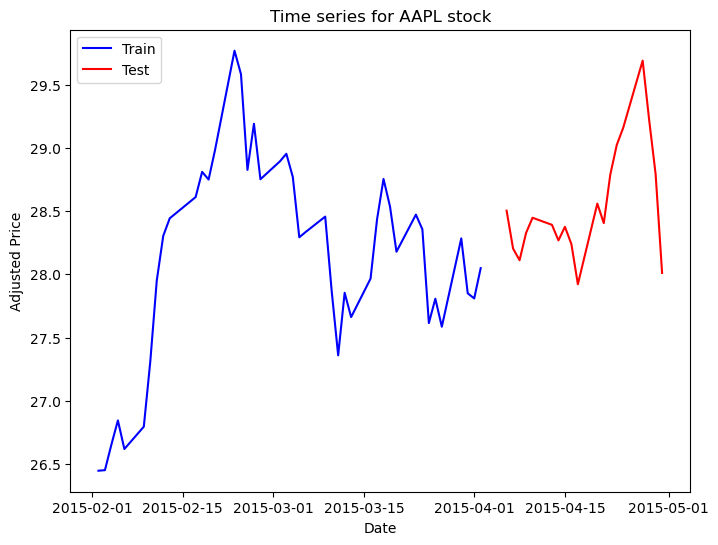

In [154]:
plt.plot(df_Apple_train_p['Date'],df_Apple_train_p['Adj Close'],color='blue',label='Train')
plt.plot(df_Apple_test_p['Date'],df_Apple_test_p['Adj Close'],color='red',label='Test')
plt.xlabel('Date')
plt.ylabel('Adjusted Price')
plt.title('Time series for AAPL stock')
plt.legend()
plt.savefig('figures/RL/prices_overall.png')
plt.show()

We will follow now the data preprocessing analysis of notebook 4. There are a few more explanations in notebook 4, the notebook defining the auxiliary functions and the doc strings, we direct the interested reader to these places for more detailed explanations.

First, we need to scale the training and test data in order to feed into a learning algorithm.

In [155]:
scaled_array_train_p, scaled_array_test_p=data_process_array(df_Apple_train_p,df_Apple_test_p)

For sanity check, let us plot both training and test data

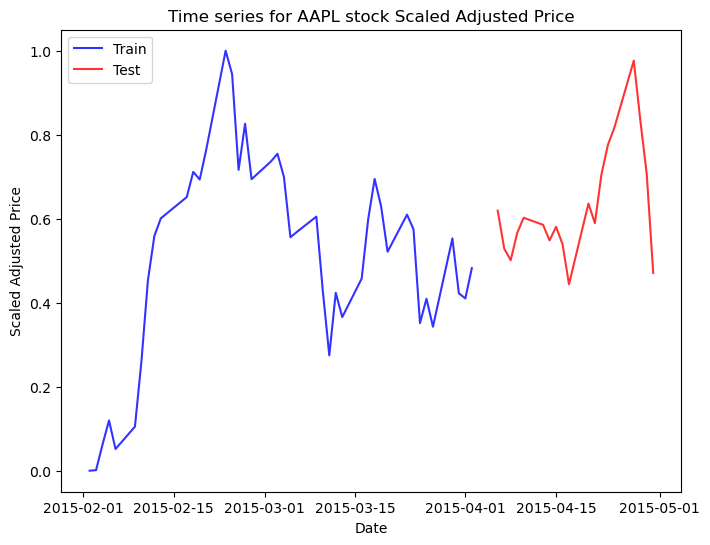

In [156]:
plt.plot(df_Apple_train_p['Date'],scaled_array_train_p[:,0],alpha=0.8,color='blue',label='Train')
plt.plot(df_Apple_test_p['Date'],scaled_array_test_p[:,0],alpha=0.8,color='red',label='Test')
plt.xlabel('Date')
plt.ylabel('Scaled Adjusted Price')
plt.title('Time series for AAPL stock Scaled Adjusted Price')
plt.legend()
plt.show()

Great, all values between $0$ and $1$ (test data could be bigger, as it is transformed from the training data fit).

As before, it is useful to define a joined dataframe with both training and test data

In [157]:
condition_joined=(df_top_30['Date']>'2015-02-01')&(df_top_30['Date']<='2015-04-30')
df_top_30_joined=df_top_30[condition_joined]
df_Apple_joined_p=df_top_30_joined[df_top_30_joined['Symbol']=='AAPL'][['Date','Adj Close']].reset_index()
df_Apple_joined_p.drop('index', axis=1, inplace=True)

Next, we want to generate rolling window interval training points.

 We will work with __rolling_window=3__, and the auxiliary function
`rolling_window_time_series` will divide the training and test time series accordingly.

In [158]:
scaled_array_train_p.shape

(43, 1)

In [159]:
X_train_p,y_train_p=rolling_window_time_series(scaled_array_train_p,3)
X_test_p,y_test_p=rolling_window_time_series(scaled_array_test_p,3)

In [160]:
# Let us print the shape of the objects. X_train should be (n_input-window,window,1)
print("X_train :",X_train_p.shape,"y_train :",y_train_p.shape)
print("X_test :",X_test_p.shape,"y_test :",y_test_p.shape)

X_train : (40, 3, 1) y_train : (40, 1)
X_test : (16, 3, 1) y_test : (16, 1)


Once more, useful to generate a rolling window that contains all the data.

In [161]:
scaled_joined_p=np.concatenate((scaled_array_train_p, scaled_array_test_p), axis=0)

In [162]:
X_joined_p,y_joined=rolling_window_time_series(scaled_joined_p,3)

For the q-learning problem, I also need to create unscaled arrays rolling window.

### it is useful to also define a training array of the original prices unscaled

In [163]:
X_train_og_p,y_train_og_p=rolling_window_time_series(df_Apple_train_p['Adj Close'].values.reshape(-1,1),3)

In [164]:
list_dates_joined=df_Apple_joined_p['Date'].iloc[3:].tolist()

## Part 2 - Simple Recurrent Neural Network for Forecasting

Recall the auxiliar function we created in order to fit Neural Networks. Let us try a few learning_rates as a quick hyperparameter check. 

In [165]:
print(neural_network_run_RNN.__doc__)


    The function to train and fit neural networks! Created the base example the architecture that was mostly successful 
    for all architectures, but still put enough of hyperparameters as optional inputs so we can experiment with them. 

    Use simple Recurrent Neural Network as architecture!

    Input:
    ------
    X_train: Shape (n_input-window,window,1), the training data for the neural network.

    y_train: Shape (n_input-window,1), the value at window+1 used as a target for training.

    experiment: String describing the experiment, useful for labeling the logs. For instance, for a hidden_states experiment, call
    the f-string f'hiddenlayers_{hidden_states}'

    hidden_states: We fix the architecture as 40-hidden_states-40-1, default is hidden_states=80.

    activation: Activation function for the 40-hidden_states-40 layers, default is ReLU.

    dropout: Dropout of nodes, useful to control overfitting when it is important. Default is dropout=0.05.

    flag_optimize

In [166]:
learning_rates=[0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.003,0.005,0.007]
models_dict_RNN = {}
mse_RNN_test=[]
mse_RNN_train=[]
for lr in learning_rates:
    experiment=f'RL_lr_{lr}'

    model, model_history=neural_network_run_RNN(X_train_p,y_train_p,experiment,learning_rate=lr)

    # Save the model 
    
    models_dict_RNN[f'RNN_{experiment}'] = model


    
    # Predict using X_joined, outputs the model prediction in the range X_train[40:] and X_test[:]
    y_predict = models_dict_RNN[f'RNN_{experiment}'].predict(X_joined_p,verbose=0)


    # Create a DataFrame with the prediction
    
    df_y_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_predict[:,0]})

    # Create an array with the predictions only in the dates of y_test, as we want to calculate MSE for the test data.
    
    scaled_array_test_predict=df_y_predict[df_y_predict['Date'].isin(df_Apple_test_p['Date'])]['Adj Close'].values

    # Compare forecasted with the test data
    
    mse_train= model_history.history['loss'][-1]
    mse_test=mse(scaled_array_test_p[:,0],scaled_array_test_predict).numpy()


    #Append to list
    mse_RNN_train.append(mse_train)
    mse_RNN_test.append(mse_test)

Working on experiment RL_lr_0.0005
Working on experiment RL_lr_0.0006
Working on experiment RL_lr_0.0007
Working on experiment RL_lr_0.0008
Working on experiment RL_lr_0.0009
Working on experiment RL_lr_0.001
Working on experiment RL_lr_0.003
Working on experiment RL_lr_0.005
Working on experiment RL_lr_0.007


In [167]:
mse_RNN_test

[0.01553798,
 0.025299387,
 0.018832762,
 0.017296694,
 0.020049684,
 0.02426728,
 0.042043716,
 0.019776113,
 0.022493118]

It seems like $0.0005$ was the best learning_rate.

#### Plot

Let us focus on the most successful model.

In [168]:
y_RNN_predict = models_dict_RNN[f'RNN_RL_lr_0.0005'].predict(X_joined_p,verbose=0)

Put in a DataFrame

In [169]:
df_y_RNN_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_RNN_predict[:,0]})

The neural network gives predictions scaled with the MinMax over the training data. We use the auxiliary function `data_process_inverse_array` to scale back to the original prices.

In [170]:
y_RNN_predict_unscaled=data_process_inverse_array(df_Apple_train_p,y_RNN_predict)

Let us create a DataFrame for the unscaled prediction

In [171]:
df_y_RNN_predict_unscaled=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_RNN_predict_unscaled[:,0]})
df_y_RNN_predict_unscaled_plot=df_y_RNN_predict_unscaled[df_y_RNN_predict_unscaled['Date'].isin(df_Apple_test_p['Date'])]

We are ready to plot our prediction

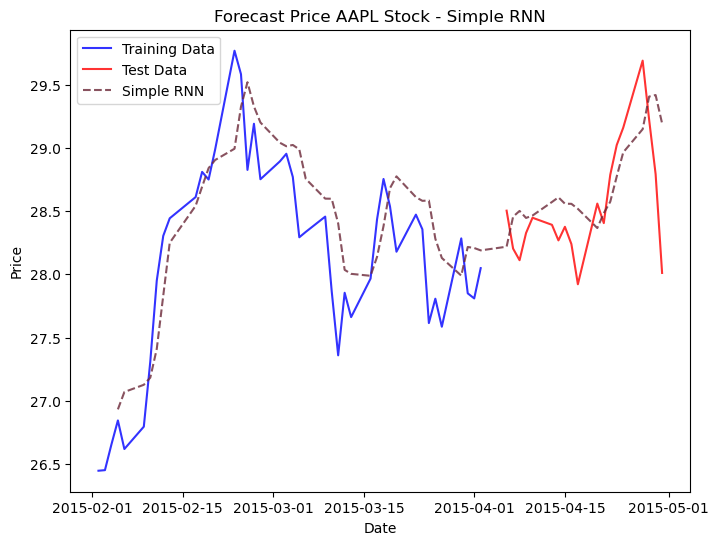

In [172]:
plt.plot(df_Apple_train_p['Date'],df_Apple_train_p['Adj Close'],alpha=0.8,color='blue',label='Training Data')
plt.plot(df_Apple_test_p['Date'],df_Apple_test_p['Adj Close'],alpha=0.8,color='red',label='Test Data')
plt.plot(df_y_RNN_predict_unscaled['Date'],df_y_RNN_predict_unscaled['Adj Close'],alpha=0.8,color='#6b2737',linestyle='dashed',label='Simple RNN')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Forecast Price AAPL Stock - Simple RNN')
plt.legend()

Since we have trained on limited data and a smaller rolling window, it makes sense that the forecast is less impressive than the ones we obtained in Notebook 4. However, our goal in this reinforcement learning is just to build a simple model to improve later, so this should be enough.

## Part 3 - Training the Q-Network

In [466]:
# Set up the environment
window_size = 3
num_actions = 3  # Buy, hold, sell
gamma = 0.95  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_min = 0.05
epsilon_decay = 0.96
batch_size = 8
#train_episodes = 100  # Number of training episodes
train_episodes = 60


# Load the pre-trained price predictor
# price_predictor = tf.keras.models.load_model('path_to_your_model.h5')
price_predictor=models_dict_RNN[f'RNN_RL_lr_0.0005']


# Initialize Q-network and target network
q_network = create_q_network(window_size)
target_network = create_q_network(window_size)
target_network.set_weights(q_network.get_weights())  # Sync target network

# Replay buffer
replay_buffer = ReplayBuffer(max_size=1500)

metrics_df = pd.DataFrame(columns=['episode', 'reward','total_reward', 'portfolio','positions','epsilon', 'epsilon_min', 'epsilon_decay'])


# Auxiliary lists
aux_price_list=df_Apple_train_p['Adj Close'].tolist()
aux_mean_test=[]
aux_std_test=[]
aux_quantity=[]
for t in range(0, len(X_train_p)):
    aux_mean_test.append(np.mean(aux_price_list[:t+3]))
    aux_std_test.append(np.std(aux_price_list[:t+3]))
    quantity_want=(aux_price_list[3-1+t]-np.mean(aux_price_list[:t+3]))/np.std(aux_price_list[:t+3])
    aux_quantity.append(quantity_want)


In [467]:
# keep track of q-values and loss if needed to debug and/or evaluate model
losses_dict={}
q_values_dict={}
aux_price_list=df_Apple_train_p['Adj Close'].tolist()
for episode in range(train_episodes):
    # Initial portfolio value
    portfolio = 1000

    # Initial number of positions
    positions = 20
    
    total_reward = 0

    # keep track of q-values and loss if needed to debug and/or evaluate model
    losses_list = []
    q_values_list = []

    for t in range(len(X_train_p)):
        state = X_train_p[t]
        current_price = X_train_og_p[t][-1]

        predicted_price = price_predictor.predict(state[np.newaxis], verbose=0)[0][0]
        augmented_state = np.append(state.flatten(), predicted_price).reshape(1, -1, 1)

        q_values = q_network.predict(augmented_state, verbose=0)
        action = choose_action(q_values, epsilon)

        # Execute action
        if action == 0 and portfolio >= current_price:  # Buy
            positions += 1
            portfolio -= current_price
        elif action == 2 and positions > 0:  # Sell
            positions -= 1
            portfolio += current_price

        # If the action is Hold, we do not need to do something

        # Auxiliary mean and std, using the data we have access to the past.
        aux_mean = np.mean(aux_price_list[:t+3])
        aux_std = max(np.std(aux_price_list[:t+3]),0.0001)

        
        # Calculate reward
        reward = calculate_reward(portfolio, positions, current_price, action, aux_mean, aux_std,augmented_state)
        total_reward += reward

        # Store experience
        if t < len(X_train_p) - 1:
            next_state = X_train_p[t + 1]
            next_predicted_price = price_predictor.predict(next_state[np.newaxis], verbose=0)[0][0]
            next_augmented_state = np.append(next_state.flatten(), next_predicted_price).reshape(-1, 1)

            replay_buffer.store((augmented_state.reshape(-1, 1), action, reward, next_augmented_state))

        # Train the Q-network
        q_values_batch, loss = train_q_network(q_network, target_network, replay_buffer, batch_size, gamma)
        if q_values_batch and loss:
            q_values_list.append(q_values_batch)
            losses_list.append(loss)

    # Log results
    losses_dict[f'episode_{episode+1}'] = losses_list
    q_values_dict[f'episode_{episode+1}'] = q_values_list

    # Update epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Periodically update target network
    if episode % 10 == 0:
        update_target_network(q_network, target_network)

    # Save checkpoints and metrics
    if (episode + 1) % 1 == 0:
        metrics_df = log_episode_data(
            episode=episode+1,
            q_network=q_network,
            replay_buffer=replay_buffer,
            metrics_df=metrics_df,
            reward=reward,
            total_reward=total_reward,
            portfolio=portfolio,
            positions=positions,
            epsilon=epsilon,
            epsilon_min=epsilon_min,
            epsilon_decay=epsilon_decay
        )

    print(f"Episode {episode+1}/{train_episodes}, Reward: {reward.item():.2f}, Total Reward: {total_reward.item():.2f}, Epsilon: {epsilon:.2f}")


/Users/hmarrochiowork/Brainstation/Capstone/offline/Sprint-3/EDA_auxiliary_functions3.py:1681: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Episode 1/60, Reward: 0.92, Total Reward: 4.90, Epsilon: 0.96
Episode 2/60, Reward: 1.07, Total Reward: -3.10, Epsilon: 0.92
Episode 3/60, Reward: 1.16, Total Reward: 1.63, Epsilon: 0.88
Episode 4/60, Reward: 0.48, Total Reward: -3.32, Epsilon: 0.85
Episode 5/60, Reward: 0.19, Total Reward: -3.88, Epsilon: 0.82
Episode 6/60, Reward: 0.54, Total Reward: -2.83, Epsilon: 0.78
Episode 7/60, Reward: 1.26, Total Reward: -4.48, Epsilon: 0.75
Episode 8/60, Reward: 0.38, Total Reward: -6.19, Epsilon: 0.72
Episode 9/60, Reward: 0.19, Total Reward: -3.90, Epsilon: 0.69
Episode 10/60, Reward: 0.54, Total Reward: -2.10, Epsilon: 0.66
Episode 11/60, Reward: 0.10, Total Reward: -4.13, Epsilon: 0.64
Episode 12/60, Reward: 0.48, Total Reward: -3.40, Epsilon: 0.61
Episode 13/60, Reward: 0.19, Total Reward: -8.68, Epsilon: 0.59
Episode 14/60, Reward: 0.89, Total Reward: 1.85, Epsilon: 0.56
Episode 15/60, Reward: 0.11, Total Reward: -9.59, Epsilon: 0.54
Episode 16/60, Reward: 0.52, Total Reward: -1.80, Ep

## Part 4 - Exploring the Q-Network

Let us investigate how the loss evolves per episode. We are essentially averaging over all the individual losses in `X_train_p`

In [473]:
losses_per_episode=[]
for i in range(1,train_episodes):
    losses_per_episode.append(np.mean(losses_dict[f'episode_{i}']))

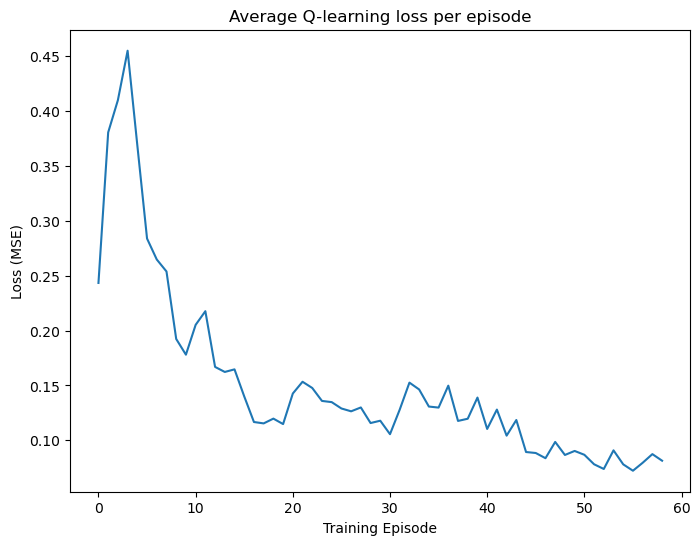

In [486]:
plt.plot(losses_per_episode)
plt.title('Average Q-learning loss per episode')
plt.xlabel('Training Episode')
plt.ylabel('Loss (MSE)')
plt.savefig('figures/RL/loss_episode.png')
plt.show()

We see that the loss overall had a tendency to decrease, which for the simplicty of the model and how we did not optimize hyperparameters, this is a good first indication of what a successful training could look like.

Let us load the model from the h5 file, just in order to sure how to proceed in case training had been interrupted. 

In [476]:
q_network_try=load_model('2trading_q_network_episode_60.h5')

#### Plot the prediction

Let us create a list with the actions predicted by the network. The output of the prediction is Q-values, and the action is the one corresponding to the highest Q-value.

In [481]:
actions_list2=[]
q_values_list2=[]
for t in range(0, len(X_joined_p)):
    state = X_joined_p[t]

    predicted_price = price_predictor.predict(state[np.newaxis], verbose=0)[0][0]

    augmented_state = np.append(state.flatten(), predicted_price).reshape(1, -1, 1)  # Shape: (1, 4, 1)

    # Get Q_values prediction from the Q-network we trained
    q_values = q_network_try.predict(augmented_state, verbose=0) 
    q_values_list2.append(q_values)

    #Action should be the largest Q-value
    actions = np.argmax(q_values, axis=1)
    actions_list2.append(actions.item())

Now let us run a trading simulation. We start with $\$ 1000$ dollars and $20$ positions, as we trained.

I also plot wealth, which is the total amount of assets we have at a given day: both money not invested, as well as the amount of positions multiplied by the price that day.

In [487]:
portfolio_p=1000
positions_p=20
prices_nice_list2=df_Apple_joined_p['Adj Close'].tolist()[3:62]
wealth_list2=[]
portfolio_trading_day2=[]
positions_trading_day2=[]

for index,action in enumerate(actions_list2):
    portfolio_old=portfolio_p

    # Map the actions predicted by Q-learning in order to simulate the trading
    if action==0:
        portfolio_p-=prices_nice_list2[index]
        positions_p+=1
    elif action==1:
        pass
    elif action==2 and positions_p>0:
        positions_p-=1
        portfolio_p+= prices_nice_list2[index]

    # Append the values to the list
    
    portfolio_trading_day2.append(portfolio_p)
    positions_trading_day2.append(positions_p)
    wealth=portfolio_p+(positions_p*prices_nice_list2[index])
    wealth_list2.append(wealth)

        
        
        
    


We are ready to plot our results. First, notice how we were successful in increasing our `wealth`, despite how primitive the model is - for instance, we can't even sell or buy more than one position a day! The important trend is that whenever the price was increasing, we had an incentive to sell positions, adn when it was decreasing, we would hold or buy. Notice that the data to the right of the black line is unseen data. 

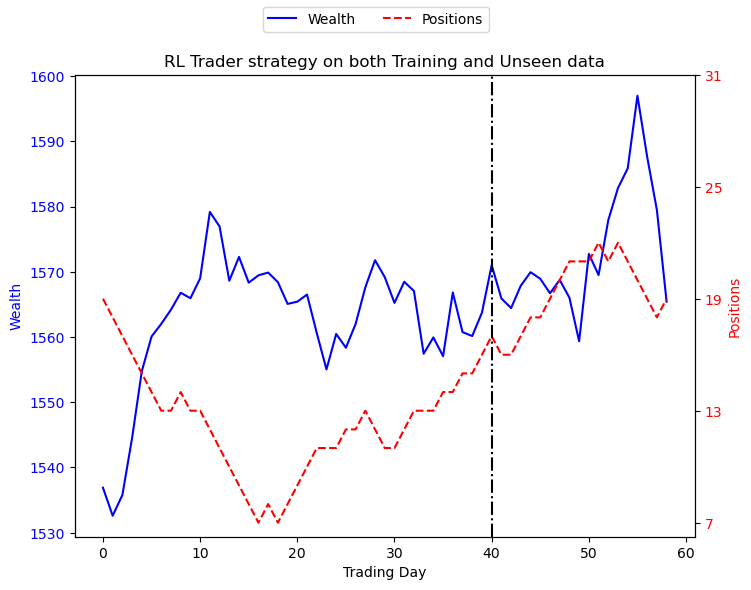

In [492]:
# Create the figure and the first y-axis
fig, ax1 = plt.subplots()

# Plot the first line on the left y-axis
ax1.plot(wealth_list2, color='b', linestyle='-', label='Wealth')
ax1.set_xlabel('Trading Day')
ax1.set_ylabel('Wealth', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create the second y-axis
ax2 = ax1.twinx()

# Plot the second line on the right y-axis
ax2.plot(positions_trading_day2, color='r', linestyle='--',label='Positions')
ax2.set_ylabel('Positions', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_yticks(range(min(positions_trading_day2), max(positions_trading_day2) + 10, 6))


# Add a title
plt.title('RL Trader strategy on both Training and Unseen data')

plt.axvline(x=40, color='black', linestyle='-.')


# Optional: Add legends for clarity
fig.legend(loc="upper center", ncol=2)

fig.savefig('figures/RL/wealth_and_position2.png')


# Show the plot
plt.show()

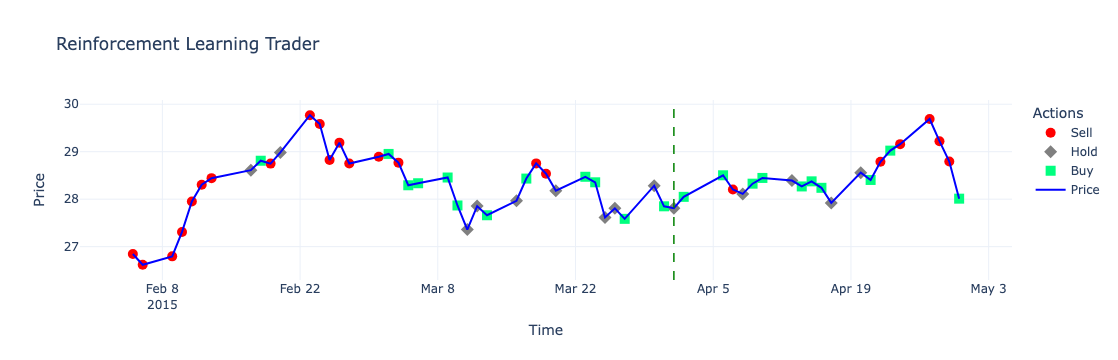

In [493]:
import plotly.express as px
import pandas as pd

time = list(range(len(prices_nice_list2)))

custom_colors = {
    "Buy": "#00FF7F",
    "Sell": "red",
    "Hold": "gray"
}

# Create a DataFrame for easier handling
data = pd.DataFrame({
    "Time": list_dates_joined,
    "Price": prices_nice_list2,
    "Action": actions_list2
})

# Map actions to custom labels
data["Action Label"] = data["Action"].map({1: "Hold", 0: "Buy", 2: "Sell"})

# Use Plotly Express scatter to group actions for legend
fig = px.scatter(
    data,
    x="Time",
    y="Price",
    color="Action Label",  # Group by actions for distinct legend entries
    symbol="Action Label",  # Use different symbols for actions
    color_discrete_map=custom_colors,  # Add custom colors
    title="Reinforcement Learning Trader",
    labels={"Price": "Price", "Time": "Time", "Action Label": "Action"},  # Customize labels
)

# Add the price line
fig.add_scatter(
    x=data["Time"],
    y=data["Price"],
    mode="lines",
    line=dict(color="blue", width=2),
    name="Price"
)

fig.add_vline(
    x=pd.Timestamp('2015-04-01')  ,
    line_width=1.5,
    line_dash="dash",
    line_color="green"
)



# Update layout
fig.update_traces(marker=dict(size=10))  # Adjust marker size
fig.update_layout(
    template="plotly_white",
    legend_title_text="Actions",  # Customize legend title
)

fig.write_html("figures/RL/Final_plot.html")

# Show the plot
fig.show()


This is the main plot of our Reinforcement Learning for now. Some very important properties: The RL trader was selling the positions as the price was high, then for a long time was alternating between buying and holding.

One very nice feature of this experiment is that whenever it saw another rise in price the test data, it started selling again to make a profit, and we see it was done selling by the last point, as comparing to the previous moving average, it is probably crossing a low price point again.

We stress that this is only a backbone computation of the basics of Q-learning for trading. I plan to expand on it for future projects, and there are many exciting avenues to explore! For instance, it would be useful to understand the hyperparameters better, increase the amount of positions we can sell/buy in a trading day, get better at dynamically defining reward.